In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    VotingRegressor,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor

tsunami_dataset = "Tsunami.csv"

In [9]:
tsunami_df = pd.read_csv(tsunami_dataset)

tsunami_df = tsunami_df[
    [
        "Tsunami Event Validity",
        "Earthquake Magnitude",
        "Latitude",
        "Longitude",
        "Number of Runups",
    ]
].dropna(
    subset=[
        "Tsunami Event Validity",
        "Earthquake Magnitude",
        "Latitude",
        "Longitude",
        "Number of Runups",
    ]
)

print("Preprocessed DataFrame shape:", tsunami_df.shape)

Preprocessed DataFrame shape: (1691, 5)


In [10]:
print("Number of Runups Statistics:")
print(tsunami_df["Number of Runups"].describe())
print(f"\nUnique values: {tsunami_df['Number of Runups'].nunique()}")
print(
    f"Data is heavily right-skewed: median={tsunami_df['Number of Runups'].median():.0f}, max={tsunami_df['Number of Runups'].max():.0f}"
)

print("\n" + "=" * 50)
print("Correlation with Number of Runups:")
print("=" * 50)
numeric_cols = [
    "Tsunami Event Validity",
    "Earthquake Magnitude",
    "Latitude",
    "Longitude",
]
for col in numeric_cols:
    corr = tsunami_df[[col, "Number of Runups"]].corr().iloc[0, 1]
    print(f"{col:25s}: {corr:6.3f}")

Number of Runups Statistics:
count    1691.000000
mean       17.991721
std       175.902663
min         0.000000
25%         1.000000
50%         2.000000
75%         5.000000
max      6421.000000
Name: Number of Runups, dtype: float64

Unique values: 115
Data is heavily right-skewed: median=2, max=6421

Correlation with Number of Runups:
Tsunami Event Validity   :  0.073
Earthquake Magnitude     :  0.164
Latitude                 :  0.005
Longitude                :  0.008


In [11]:
tsunami_df["Eq_Magnitude_Squared"] = tsunami_df["Earthquake Magnitude"] ** 2
tsunami_df["Coastal_Distance"] = np.sqrt(
    tsunami_df["Latitude"] ** 2 + tsunami_df["Longitude"] ** 2
)
tsunami_df["Is_Pacific_Ring"] = (
    (tsunami_df["Latitude"].between(10, 60))
    & (
        tsunami_df["Longitude"].between(120, 180)
        | tsunami_df["Longitude"].between(-180, -100)
    )
).astype(int)

features = [
    "Tsunami Event Validity",
    "Earthquake Magnitude",
    "Eq_Magnitude_Squared",
    "Latitude",
    "Longitude",
    "Coastal_Distance",
    "Is_Pacific_Ring",
]

X = tsunami_df[features].fillna(0)
y = np.log1p(tsunami_df["Number of Runups"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print("Using 7 dominant features (event validity, magnitude, spatial cues)")

Training set: (1352, 7)
Test set: (339, 7)
Using 7 dominant features (event validity, magnitude, spatial cues)


In [12]:
param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

param_grid_gb = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "min_samples_split": [2, 5, 10],
}

param_grid_xgb = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "min_child_weight": [1, 3, 5],
}

print("Tuning Random Forest...")
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid_rf,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=1,
)
rf_grid.fit(X_train, y_train)
rf_tuned = rf_grid.best_estimator_

print("\nTuning Gradient Boosting...")
gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gb,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=1,
)
gb_grid.fit(X_train, y_train)
gb_tuned = gb_grid.best_estimator_

print("\nTuning XGBoost...")
xgb_grid = GridSearchCV(
    XGBRegressor(random_state=42, n_jobs=-1),
    param_grid_xgb,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=1,
)
xgb_grid.fit(X_train, y_train)
xgb_tuned = xgb_grid.best_estimator_

print("\nBest RF params:", rf_grid.best_params_)
print("Best GB params:", gb_grid.best_params_)
print("Best XGB params:", xgb_grid.best_params_)

Tuning Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Tuning Gradient Boosting...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Tuning Gradient Boosting...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Tuning XGBoost...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Tuning XGBoost...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best RF params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best GB params: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300}
Best XGB params: {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300}

Best RF params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best GB params: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300}
Best XGB params: {'learning_rate': 0.01, 'max_depth': 5, 'min_

In [13]:
ensemble = VotingRegressor([("rf", rf_tuned), ("gb", gb_tuned), ("xgb", xgb_tuned)])
ensemble.fit(X_train, y_train)

y_pred = ensemble.predict(X_test)
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"\nEnsemble Model Performance (RF + GB + XGB):")
print(f"  R² Score: {r2:.4f}")
print(f"  RMSE (log): {rmse:.4f}")
print(f"  MAE (log): {mae:.4f}")
print(f"\nOriginal Scale:")
print(
    f"  RMSE: {np.sqrt(mean_squared_error(y_test_original, y_pred_original)):.2f} runups"
)
print(f"  MAE: {mean_absolute_error(y_test_original, y_pred_original):.2f} runups")

print(f"\nIndividual Model Performance:")
for name, model in [("RF", rf_tuned), ("GB", gb_tuned), ("XGB", xgb_tuned)]:
    y_pred_ind = model.predict(X_test)
    r2_ind = r2_score(y_test, y_pred_ind)
    print(f"  {name}: R² = {r2_ind:.4f}")


Ensemble Model Performance (RF + GB + XGB):
  R² Score: 0.4103
  RMSE (log): 0.9151
  MAE (log): 0.6372

Original Scale:
  RMSE: 49.96 runups
  MAE: 11.71 runups

Individual Model Performance:
  RF: R² = 0.4450
  GB: R² = 0.3859
  XGB: R² = 0.3721


Top 10 Features:
                  feature  importance
0  Tsunami Event Validity    0.508880
1    Earthquake Magnitude    0.189009
2    Eq_Magnitude_Squared    0.118553
3                Latitude    0.064221
5        Coastal_Distance    0.054496
4               Longitude    0.052868
6         Is_Pacific_Ring    0.011973


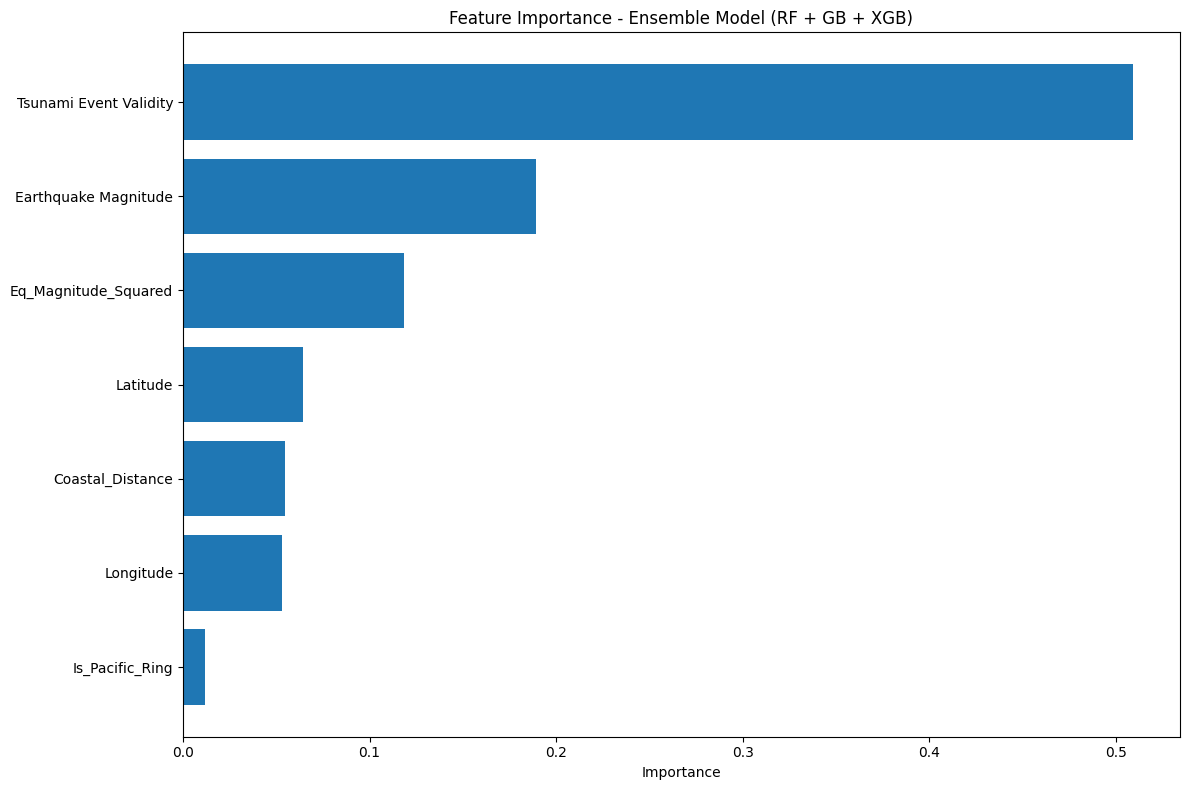

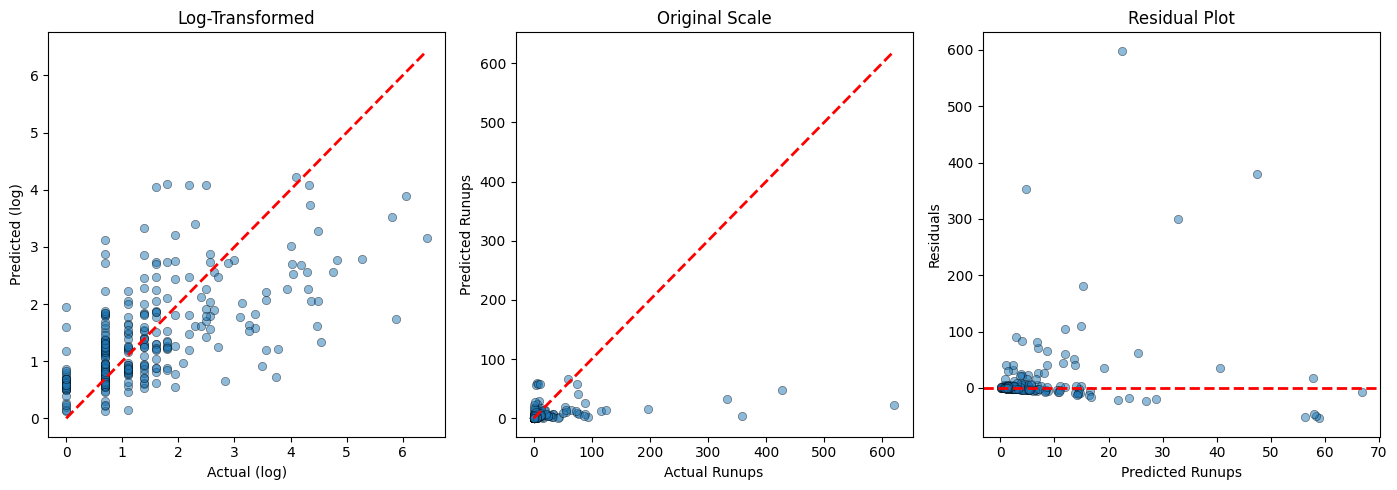


Model Summary:
  Explains 41.0% of variance
  Average error: ±11.7 runups


In [14]:
feature_importance = pd.DataFrame(
    {
        "feature": features,
        "importance": (
            rf_tuned.feature_importances_
            + gb_tuned.feature_importances_
            + xgb_tuned.feature_importances_
        )
        / 3,
    }
).sort_values("importance", ascending=False)

print("Top 10 Features:")
print(feature_importance.head(10))

plt.figure(figsize=(12, 8))
plt.barh(feature_importance["feature"], feature_importance["importance"])
plt.xlabel("Importance")
plt.title("Feature Importance - Ensemble Model (RF + GB + XGB)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors="k", linewidths=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual (log)")
plt.ylabel("Predicted (log)")
plt.title("Log-Transformed")

plt.subplot(1, 3, 2)
plt.scatter(y_test_original, y_pred_original, alpha=0.5, edgecolors="k", linewidths=0.5)
plt.plot([0, y_test_original.max()], [0, y_test_original.max()], "r--", lw=2)
plt.xlabel("Actual Runups")
plt.ylabel("Predicted Runups")
plt.title("Original Scale")

plt.subplot(1, 3, 3)
residuals = y_test_original - y_pred_original
plt.scatter(y_pred_original, residuals, alpha=0.5, edgecolors="k", linewidths=0.5)
plt.axhline(y=0, color="r", linestyle="--", lw=2)
plt.xlabel("Predicted Runups")
plt.ylabel("Residuals")
plt.title("Residual Plot")

plt.tight_layout()
plt.show()

print(f"\nModel Summary:")
print(f"  Explains {r2*100:.1f}% of variance")
print(
    f"  Average error: ±{mean_absolute_error(y_test_original, y_pred_original):.1f} runups"
)